In [1]:
#install required packages
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.8 MB/s eta 0:00:00


In [ ]:
#test GPU device
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6141309788050005079
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14328594432
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14631869806847255315
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [2]:
import torch
import torch.nn as nn
# Define a custom neural network class
class ConvertModel(nn.Module):
    def __init__(self, input_dim, output_dim,N):
        super(ConvertModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.N = N

    def forward(self, x):
        N = self.N
        x = x.view(N, -1)  # Reshape the input tensor
        x = self.linear(x)
        return x

# Create an instance of the custom class
def tensor_3d_to_2d(tensor):
  N = tensor.shape[0]
  M = tensor.shape[1]
  input_dim = M * 768
  output_dim = 768
  print(N,M)
  tensor_model = ConvertModel(input_dim, output_dim, N)
  converted_tensor = tensor_model(tensor)

  return converted_tensor




In [3]:
#add bert model
from transformers import BertTokenizerFast, BertForTokenClassification
from torch.nn.functional import softmax
import torch
#import packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import precision_score, recall_score


In [4]:
def proprocess_tweets(tweets):
  processed_tweets = [preprocessTweet1(tweet) for tweet in tweets]
  return processed_tweets
#add preprocessing step to clean the tweets
import re
def preprocessTweet1(tweet):
    # process the tweets

    # Remove 'RT' from tweet
    tweet = re.sub(r'RT[\s]+', '', tweet)
    # Remove &amp; (ampersand)
    tweet = re.sub(r'&amp;', 'and', tweet)
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    #Convert @username to @USER
    tweet = re.sub('@[^\s]+','',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    # Remove all emojis.
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    tweet = emoji_pattern.sub(r'', tweet)

    # Remove redundant spaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()

    #remove unknown characters
    tweet = ''.join([c for c in tweet if ord(c) < 128])

    #trim
    tweet = tweet.strip('\'"')
    return tweet



In [5]:
#define the tokenize, padding, masking procedure from text to tensor

def text_to_tensor(data):
  #tokenize
  tokenized = data['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
  #padding
  max_len = 0
  for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
  print("max len for padding: ",max_len, np.array(padded).shape)
  #Masking the paddding
  attention_mask = np.where(padded != 0, 1, 0)
  # print("attention mask shape:",attention_mask.shape)
  #Use pretrained Bert model to word embedding all the sentences
  input_ids = torch.tensor(padded)
  attention_mask = torch.tensor(attention_mask)

  with torch.no_grad():
      last_hidden_states = model(input_ids, attention_mask=attention_mask)
  # result =last_hidden_states

  return last_hidden_states[0]

In [6]:
# clean data
def clean_data(data):
  #clean tweets
  data['text'] = proprocess_tweets(data['text'])
  return(data)


In [7]:

#balance the data
def balanced_data(data):

  data_ade = data[data['label'] == 1]
  data_noade = data[data['label'] == 0]
  # print(data_ade.shape,data_noade.shape)
  #downsampling
  data_noade_downsampled = data_noade.sample(data_ade.shape[0])
  data_balanced = pd.concat([data_ade,data_noade_downsampled])
  # print(t_batch_balanced['label'].value_counts())
  #proprecess the tweets
  # print("before clean",t_batch_balanced)
  # #clean tweets
  # data_balanced['text'] = proprocess_tweets(data_balanced['text'])
  # print("after clean  ",data_balanced)
  return data_balanced



In [8]:
#import dataset
# test_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)
#import dataset from github
ADETrainingdata = pd.read_csv('https://raw.githubusercontent.com/FANMISUA/TweetAENormalization/main/ADEClassification/ADETraining.tsv', delimiter='\t')
ADEValidationdata = pd.read_csv('https://raw.githubusercontent.com/FANMISUA/TweetAENormalization/main/ADEClassification/ADEValidation.tsv', delimiter='\t')

In [9]:
print("Training data shape:",ADETrainingdata.shape)
print("Validation data shape:",ADEValidationdata.shape)

Training data shape: (7600, 3)
Validation data shape: (400, 3)


In [ ]:
#import normalization data
RawTweets = pd.read_csv('https://raw.githubusercontent.com/FANMISUA/TweetAENormalization/main/ADENormalization/Dev/tweets.tsv',delimiter='\t')
SpansNorm = pd.read_csv('https://raw.githubusercontent.com/FANMISUA/TweetAENormalization/main/ADENormalization/Dev/spans_norm.tsv',delimiter='\t')

#check the tweets id in Spans Norm and Raw Tweets
# print("get the tweets id in Raw Tweets:\n",RawTweets.iloc[:,0])
# print("Get the tweets id in Spans Norm:\n",SpansNorm.iloc[:,0])
list1 = RawTweets.iloc[:,0]
list2 = SpansNorm.iloc[:,0]
common_values = set(list1).intersection(set(list2))
# print("common tweets id:",common_values)
# print("Total tweets:",len(set(list1)),"Tweets with AE:",len(set(list2)),"matched tweets:",len(common_values))

In [10]:
# train the ADE model with 7600 ADETrainingData
#print(ADETrainingdata.head() , ADEValidationdata.head())
#use the first 2000 rows of the training data
# ADETrainingdata[:2000]
# ADETrainingdata.iloc[:3,-3:]
#ADETrainingdata['tweet_id'][:200]
#only use the first 300 tweets in Training data as training
# print(ADETrainingdata['label'][:300].value_counts())
# training_batch_1 =ADETrainingdata[:300]
training_batch_1 =ADETrainingdata[:1000]
# training_batch_1 = balanced_data(training_batch_1)

# print(training_batch_1.head())
print("Training data shape",training_batch_1.shape)
print("Training data label distribution:\n",training_batch_1['label'].value_counts())

#testing dataset from validation dataset
#use first 100 for coding
# print(ADEValidationdata['label'][:100].value_counts())
testing_batch_1 =ADEValidationdata[:100]
print("Testing data shape",testing_batch_1.shape)
print("Testing data label distribution:\n",testing_batch_1['label'].value_counts())
# print(testing_batch_1.head())

Training data shape (1000, 3)
Training data label distribution:
 0    825
1    175
Name: label, dtype: int64
Testing data shape (100, 3)
Testing data label distribution:
 0    88
1    12
Name: label, dtype: int64


In [11]:
# proprecess training data: cleaning the tweets text
#balance data
# bal_training_data = balanced_data(training_batch_1)
#clean data
# clean_training_data = clean_data(bal_training_data)
#clean the training data tweets
clean_training_data = clean_data(training_batch_1)

# print(bal_data)
print("training data shape:",training_batch_1.shape,"clean training data shape",clean_training_data.shape)

# proprecess testing data
#all clean testing data unbalanced
clean_testing_data = clean_data(testing_batch_1)
#all testing data
print("testing data shape:",testing_batch_1.shape,"clean testing data shape:",clean_testing_data.shape)
#balance testing data
# bal_testing_data = balanced_data(testing_batch_1)
#clean balanced testing data
# clean_testing_data = clean_data(bal_testing_data)

# print("testing data shape:",testing_batch_1.shape,"all clean testing data shape:",all_testing_data.shape,
#       "clean balanced testing data shape:",clean_testing_data.shape)


training data shape: (1000, 3) clean training data shape (1000, 3)
testing data shape: (100, 3) clean testing data shape: (100, 3)


In [12]:
#load bert model. load tokenizer and model
#Testing small bert model 'distilbert-base-uncased'
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
#testing pubmed bert model
# model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'ml4pubmed/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext_pub_section')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [13]:
# print(clean_training_data)
# calculate the time to do tokenization
# first step to convert the text into tensor
import time
start_time = time.time()
features_train_1 = text_to_tensor(clean_training_data)
features_test_1 = text_to_tensor(clean_testing_data)
end_time = time.time()
tokenize_time = end_time - start_time
print(f"Running time: {tokenize_time:.4f} seconds")

print("training features dimension",features_train_1.shape)
print("testing features dimension",features_test_1.shape)

max len for padding:  89 (1000, 89)
max len for padding:  82 (100, 82)
Running time: 194.5062 seconds
training features dimension torch.Size([1000, 89, 768])
testing features dimension torch.Size([100, 82, 768])


In [ ]:
#add NN layer to convert 3D tensor to 2D tensor
# print(fe_train_1.shape, fe_test_1.shape, fe_test_2.shape)
# fe_train_1_2d = tensor_3d_to_2d(fe_train_1).detach().numpy()
# fe_test_1_2d = tensor_3d_to_2d(fe_test_1).detach().numpy()
# fe_test_2_2d = tensor_3d_to_2d(fe_test_2).detach().numpy()
# print(fe_train_1_2d.shape, fe_test_1_2d.shape, fe_test_2_2d.shape)


In [14]:
# print(features_train_1.shape)
features_train_1_2d = features_train_1[:,0,:].numpy()
features_test_1_2d = features_test_1[:,0,:].numpy()
labels_train_1_2d = clean_training_data['label']
labels_test_1_2d = clean_testing_data['label']
print("dimension for features in training:",features_train_1_2d.shape,"dimension for features in testing:",features_test_1_2d.shape)
print("lables in training:",labels_train_1_2d.shape, "labels in testing:",labels_test_1_2d.shape)
# print(labels_test_1_2d)

dimension for features in training: (1000, 768) dimension for features in testing: (100, 768)
lables in training: (1000,) labels in testing: (100,)


In [ ]:
# ex_X_test, ex_y_test = features_test_1_2d[:100], labels_test_1_2d[:100]
# print(ex_X_test.shape,ex_y_test.shape)

(100, 768) (100,)


In [19]:
# add 5 fold cross validation and repeat 100 times
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, accuracy_score


num_repeats = 10
num_folds = 5
#repeat 100 times for 5 fold cross validation
rkf = RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats, random_state=42)

# Initialize the under-sampler
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)



precision_scores = []
recall_scores = []
f1_scores = []

ex_precision_scores = []
ex_recall_scores = []
ex_f1_scores = []

# ex_X_test, ex_y_test = features_test_1_2d, labels_test_1_2d
ex_X_test, ex_y_test = features_test_1_2d[:100], labels_test_1_2d[:100]
# print(ex_X_test.shape,ex_y_test.shape)

# print(features_train_1_2d[0],labels_train_1_2d[0])
for train_index, test_index in rkf.split(features_train_1_2d):
    # print(train_index.shape,test_index.shape)
    X_train, X_test = features_train_1_2d[train_index], features_train_1_2d[test_index]
    y_train, y_test = labels_train_1_2d[train_index], labels_train_1_2d[test_index]
    # print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)

    # print(y_train.value_counts())
    #balance the 4 fold training data
    # X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)
    X_train_resampled, y_train_resampled = X_train, y_train
    # print(X_train_resampled.shape,y_train_resampled)

    #define the parameter grid to search
    param_grid = {
    'C': np.linspace(0.0001, 100, 10)
    }

    # Create and train a logistic regression model
    model = LogisticRegression()
    scorer = make_scorer(accuracy_score)
    grid_search = GridSearchCV(model, param_grid, scoring=scorer)
    # Fit the grid search on the data
    grid_search.fit(X_train_resampled, y_train_resampled)
    # print(f'Best Parameters: {grid_search.best_params_}')
    # print(f'Best Accuracy: {grid_search.best_score_:.2f}')

    #use the best parameter for the model
    lr_clf = LogisticRegression(C=grid_search.best_params_['C'])
    lr_clf.fit(X_train_resampled, y_train_resampled)
    # model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on 1 fold  test
    y_pred = lr_clf.predict(X_test)
    # make prediction on external test
    ex_y_pred = lr_clf.predict(ex_X_test)

    # calcuate matrics for 1 fold test
    # Calculate precision, recall, and F1-score
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # calcuate matrics for external test
    ex_precision = precision_score(ex_y_test, ex_y_pred)
    ex_recall = recall_score(ex_y_test, ex_y_pred)
    ex_f1 = f1_score(ex_y_test, ex_y_pred)

    # add scores for 1 fold test
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # add scores for 1 fold test
    ex_precision_scores.append(ex_precision)
    ex_recall_scores.append(ex_recall)
    ex_f1_scores.append(ex_f1)


#calculate matrics for 1 fold test
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

#calculate matrics for external test
mean_ex_precision = np.mean(ex_precision_scores)
std_ex_precision = np.std(ex_precision_scores)
mean_ex_recall = np.mean(ex_recall_scores)
std_ex_recall = np.std(ex_recall_scores)
mean_ex_f1 = np.mean(ex_f1_scores)
std_ex_f1 = np.std(ex_f1_scores)

print("for 1 fold test:")
print(f"Average Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Average Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Average F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")
print("for external test :")
print(f"Average Precision: {mean_ex_precision:.4f} ± {std_ex_precision:.4f}")
print(f"Average Recall: {mean_ex_recall:.4f} ± {std_ex_recall:.4f}")
print(f"Average F1-Score: {mean_ex_f1:.4f} ± {std_ex_f1:.4f}")


# print("precision_scores:",precision_scores)
# print("recall_scores:",recall_scores)
# print("f1_scores:",f1_scores)
# print("ex precision_scores:",ex_precision_scores)
# print("ex recall_scores:",ex_recall_scores)
# print("ex f1_scores:",ex_f1_scores)



for 1 fold test:
Average Precision: 0.5029 ± 0.1897
Average Recall: 0.4379 ± 0.1657
Average F1-Score: 0.4625 ± 0.1669
for external test :
Average Precision: 0.4066 ± 0.1496
Average Recall: 0.4917 ± 0.1909
Average F1-Score: 0.4438 ± 0.1653


In [ ]:
# add 5 fold cross validation and repeat 100 times
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, accuracy_score


num_repeats = 10
num_folds = 5
#repeat 100 times for 5 fold cross validation
rkf = RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats, random_state=42)

# Initialize the under-sampler
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)



precision_scores = []
recall_scores = []
f1_scores = []

ex_X_test, ex_y_test = features_test_1_2d, labels_test_1_2d

# print(features_train_1_2d[0],labels_train_1_2d[0])
for train_index, test_index in rkf.split(features_train_1_2d):
    # print(train_index.shape,test_index.shape)
    X_train, X_test = features_train_1_2d[train_index], features_train_1_2d[test_index]
    y_train, y_test = labels_train_1_2d[train_index], labels_train_1_2d[test_index]
    # print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)

    # print(y_train.value_counts())
    #balance the 4 fold training data
    # X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)
    X_train_resampled, y_train_resampled = X_train, y_train
    # print(X_train_resampled.shape,y_train_resampled)

    #define the parameter grid to search
    param_grid = {
    'C': np.linspace(0.0001, 100, 10)
    }

    # Create and train a logistic regression model
    model = LogisticRegression()
    scorer = make_scorer(accuracy_score)
    grid_search = GridSearchCV(model, param_grid, scoring=scorer)
    # Fit the grid search on the data
    grid_search.fit(X_train_resampled, y_train_resampled)
    # print(f'Best Parameters: {grid_search.best_params_}')
    # print(f'Best Accuracy: {grid_search.best_score_:.2f}')

    #use the best parameter for the model
    lr_clf = LogisticRegression(C=grid_search.best_params_['C'])
    lr_clf.fit(X_train_resampled, y_train_resampled)
    # model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the test set
    # y_pred = lr_clf.predict(X_test)
    ex_y_pred = lr_clf.predict(ex_X_test)
    # Calculate precision, recall, and F1-score
    # precision = precision_score(y_test, y_pred)
    # recall = recall_score(y_test, y_pred)
    # f1 = f1_score(y_test, y_pred)
    precision = precision_score(ex_y_test, ex_y_pred)
    recall = recall_score(ex_y_test, ex_y_pred)
    f1 = f1_score(ex_y_test, ex_y_pred)

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

average_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
average_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
average_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
# precision_mean = np.mean(precision_scores)
# precision_std = np.std(precision_scores)
# recall_mean = np.mean(recall_scores)
# recall_std = np.std(recall_scores)
# f1_mean = np.mean(f1_scores)
# f1_std = np.std(f1_scores)

print(f"Average Precision: {average_precision:.4f} ± {std_precision:.4f}")
print(f"Average Recall: {average_recall:.4f} ± {std_recall:.4f}")
print(f"Average F1-Score: {average_f1:.4f} ± {std_f1:.4f}")
print("precision_scores:",precision_scores)
print("recall_scores:",recall_scores)
print("f1_scores:",f1_scores)




Average Precision: 0.5452 ± 0.0415
Average Recall: 0.5263 ± 0.0425
Average F1-Score: 0.5346 ± 0.0347
precision_scores: [0.5555555555555556, 0.5614035087719298, 0.5818181818181818, 0.5106382978723404, 0.5714285714285714, 0.5370370370370371, 0.56, 0.5263157894736842, 0.5081967213114754, 0.5454545454545454, 0.5178571428571429, 0.5333333333333333, 0.5416666666666666, 0.5714285714285714, 0.5454545454545454, 0.5660377358490566, 0.45614035087719296, 0.5849056603773585, 0.5344827586206896, 0.5178571428571429, 0.509090909090909, 0.4827586206896552, 0.6078431372549019, 0.5205479452054794, 0.5660377358490566, 0.5869565217391305, 0.5, 0.5471698113207547, 0.6, 0.5454545454545454, 0.5614035087719298, 0.5178571428571429, 0.5081967213114754, 0.5789473684210527, 0.48148148148148145, 0.6326530612244898, 0.5636363636363636, 0.5, 0.5370370370370371, 0.54, 0.6590909090909091, 0.5384615384615384, 0.5254237288135594, 0.5454545454545454, 0.5370370370370371, 0.4666666666666667, 0.6274509803921569, 0.6071428571

training feature dimension (1600, 768)
testing feature dimension (400, 768)
training label dimension (1600,)
training label dimension (400,)
best parameters:  {'C': 11.1112}
best scrores:  0.8556250000000001
precision 0.6323529411764706 recall: 0.5443037974683544 f1: 0.5850340136054422
Accuracy: 0.8475
MCC: 0.49433544989517164
True Negatives: 296
False Positives: 25
False Negatives: 36
True Positives: 43


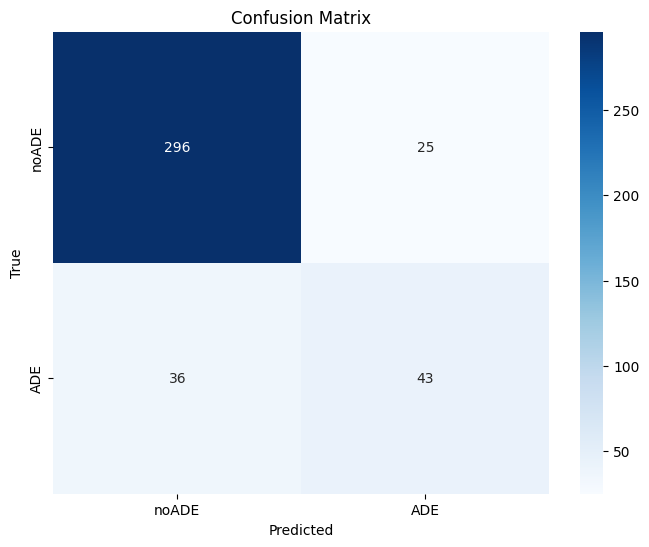

In [ ]:
#split the features and labels in training
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

ex_X_test, ex_y_test = features_test_1_2d, labels_test_1_2d


train_features, test_features, train_labels, test_labels = train_test_split(features_train_1_2d, labels_train_1_2d, test_size = 0.2, random_state = 42)
print("training feature dimension",train_features.shape)
print("testing feature dimension",test_features.shape)
print("training label dimension",train_labels.shape)
print("training label dimension",test_labels.shape)

#refine parameters for logisticRegression model
parameters = {'C': np.linspace(0.0001, 100, 10)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(train_features, train_labels)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

lr_clf = LogisticRegression(C=grid_search.best_params_['C'])
lr_clf.fit(train_features, train_labels)

lr_clf.score(test_features, test_labels)


lr_clf.score(train_features, train_labels)


predict_test_labels = lr_clf.predict(test_features)

precision_1 = precision_score(test_labels, predict_test_labels)

recall_1 = recall_score(test_labels, predict_test_labels)

f1_1 = f1_score(test_labels, predict_test_labels)
print("precision",precision_1, "recall:",recall_1, "f1:",f1_1)
accuracy_1 = accuracy_score(test_labels, predict_test_labels)
print("Accuracy:", accuracy_1)

# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(test_labels, predict_test_labels)
print("MCC:", mcc)

## Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, predict_test_labels)

# Extract TP, TN, FP, FN from the confusion matrix
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]

print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)
print("True Positives:", TP)

class_labels = ['noADE', 'ADE']
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()